# Tracking computational experiments which create files

This notebooks demonstrates how to very simply track the results of computational experiments which create files. 

We'll start by registering the molecules that we're going to work with using standard lwreg functionality and then show three different, but related, use cases of working with those molecules.

1. Generate a conformer for each molecules, calculate a few 3D descriptors for the conformers, save the conformers to an SDF file. Store the names of the SDF files and the computed descriptor values in the database
2. Generate multiple conformers for each molecule and calculate their energies. Save the conformers to an SDF file. Store the names of the SDF files and the energies in the database.
3. Read in the conformers generated in the first use case, run a simple QM calculation on them, and extract a few properties from the QM results. Store the QM results in the database.

Note that it's possible to, with a little bit more effort up-front, make the database considerably more useful (this is demonstrated in the notebook for the second computational experiment), but you can already do a *lot* with a small amount of code.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import rdDistGeom
import os
import rdkit
print(rdkit.__version__)
%load_ext sql
%config SqlMagic.named_parameters="enabled"

2024.09.5


Some data from ChEMBL

In [2]:
import pandas as pd
from io import StringIO
txt = '''"standard_relation","standard_value","standard_type","pchembl_value","assay_chembl_id","target_chembl_id","canonical_smiles","compound_chembl_id"
">",10000.0,"Ki",,"CHEMBL615807","CHEMBL214","CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\C=C/C(=O)O","CHEMBL1794855"
"=",168.0,"Ki",6.78,"CHEMBL615460","CHEMBL214","CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C","CHEMBL278751"
"=",181.0,"Ki",6.74,"CHEMBL615809","CHEMBL214","C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4","CHEMBL103772"
"=",3.9,"Ki",8.41,"CHEMBL615460","CHEMBL214","CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23","CHEMBL328107"
"=",1.6,"Ki",8.8,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5csc6ccccc56)Oc12","CHEMBL148860"
"=",210.0,"Ki",6.68,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(C1)ccc3ccoc23","CHEMBL96735"
"=",1.7,"Ki",8.77,"CHEMBL616120","CHEMBL214","CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc4c3ccc5ccccc45)c1","CHEMBL111065"
"=",344.0,"Ki",6.46,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(O)cccc2C1","CHEMBL273273"
"=",127.7,"Ki",6.89,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3C4CCC3C=C(C4)n5ccc6cc(F)ccc56)Oc12","CHEMBL150050"
"=",5.87,"Ki",8.23,"CHEMBL615756","CHEMBL214","CCOc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5ccc6ccccc6c5)Oc12","CHEMBL151786"
'''
sio = StringIO(txt)
df = pd.read_csv(sio)
df.head()

<>:3: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipykernel_3379498/688675569.py:3: SyntaxWarning: invalid escape sequence '\C'
  txt = '''"standard_relation","standard_value","standard_type","pchembl_value","assay_chembl_id","target_chembl_id","canonical_smiles","compound_chembl_id"


,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


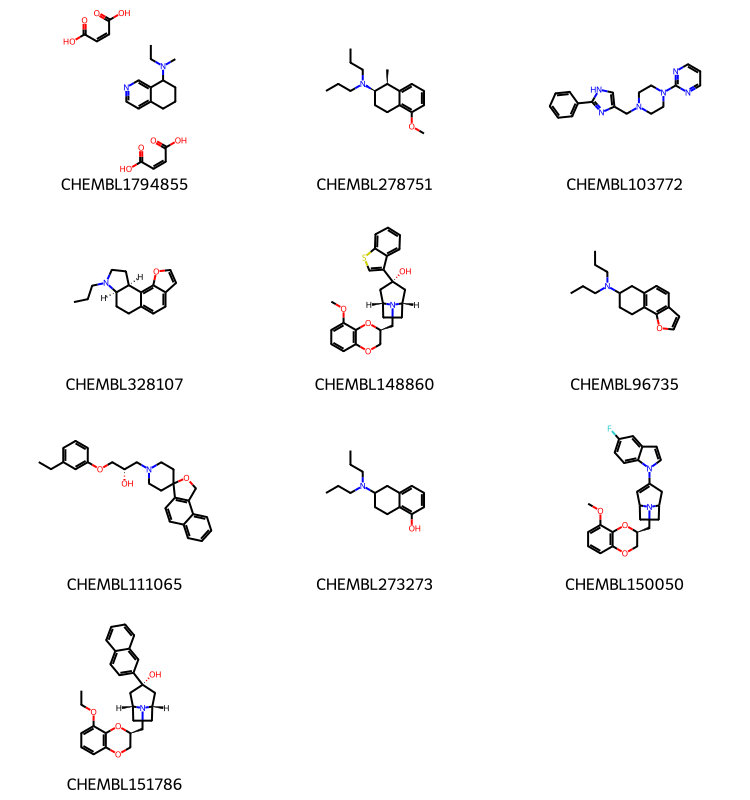

In [3]:
ms = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles]
Draw.MolsToGridImage(ms,legends=list(df.compound_chembl_id),molsPerRow=3,subImgSize=(250,200))

In [4]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils

config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'sqlite3'
config['dbname'] = 'lwreg_experiments_demo.sqlite3'
# be explicit about what our standardization is:
config['standardization'] = standardization_lib.ChargeParent()
lwreg.set_default_config(config)

Initialize the database. **Note** that this erases everything in the current database, so be very careful with this command!

In [5]:
lwreg.initdb()

This will destroy any existing information in the registration database.


  are you sure? [yes/no]:  yes


True

Register all of our compounds at once:

In [6]:
# The RDKit standardizer is quite verbose by default, make it be quiet:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

In [7]:
# now bulk register. We want to also collect IDs of compounds which were already registered.
reg_ids = lwreg.bulk_register(mols=ms,fail_on_duplicate=False)
reg_ids = set(reg_ids)
print(f'Registered {len(reg_ids)} unique compounds.')

Registered 10 unique compounds.


In [8]:
reg_ids

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

Get the registered mol blocks from lwreg and convert them to molecules.

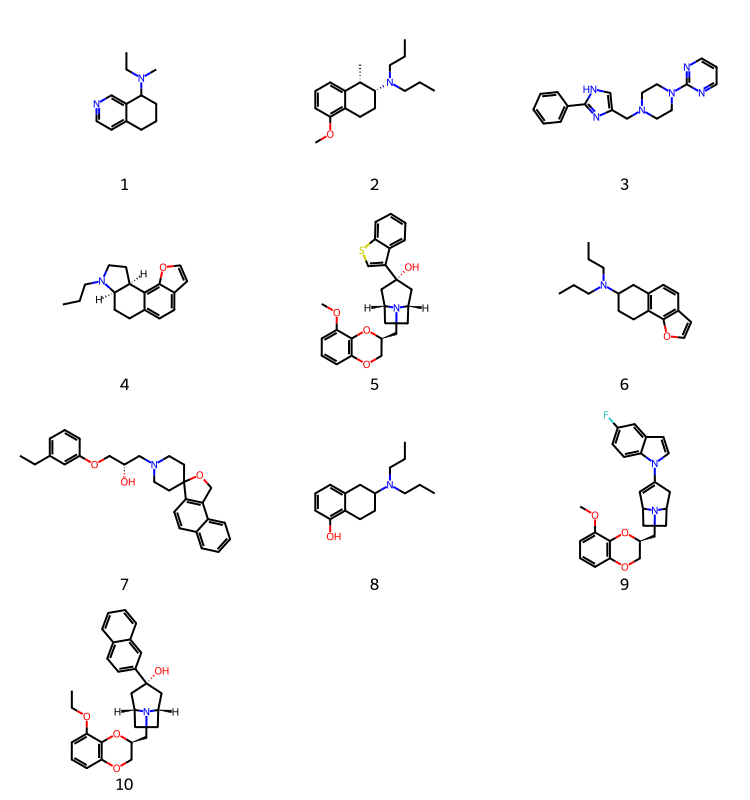

In [9]:
mol_data = lwreg.retrieve(ids=list(reg_ids))
mids,new_mols = zip(*[(mid,Chem.MolFromMolBlock(d)) for mid,(d,_) in mol_data.items()])
Draw.MolsToGridImage(new_mols,legends=[str(x) for x in mids],molsPerRow=3,subImgSize=(250,200))

# Set up schema to hold experiments and results in the database:

Initialize the experiment database. **Note** that executing this cell destroys the data in the existing experiments tables

In [10]:
cn = utils.connect(config)
curs = cn.cursor()
curs.execute('drop table if exists experiments_metadata')
curs.execute('create table experiments_metadata (expt_uid text primary key,metadata jsonb)')
curs.execute('drop table if exists experiments_data')
curs.execute('create table experiments_data (result_id integer primary key, expt_uid text not null,molregno int not null,data jsonb)')
cn.commit()

In [11]:
from datetime import datetime
def non_default_params_to_dict(obj,defaults):
    res = {}
    for k in dir(obj):
        if k.startswith('__'):
            continue
        v = getattr(obj,k)
        if callable(v):
            continue
        if v == getattr(defaults,k):
            continue
        else:
            res[k] = v
    return res


# Part1: Generate conformers and storing results in files

It's also possible to store the conformers directly in the database; this will be demonstrated in a different notebook.

In [12]:
from rdkit.Chem import rdMolDescriptors
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.numThreads = 8

dg_metadata = non_default_params_to_dict(ps,rdDistGeom.ETKDGv3())

cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':1,
    'note':'run1: 3D conformers of some ChEMBL molecules + some 3D descriptors'
}
cg_expt_metadata.update(dg_metadata)

In [13]:
m3ds = []
for mid,m in zip(mids,new_mols):
    mh = Chem.AddHs(m)
    cid = rdDistGeom.EmbedMolecule(mh,ps)
    if cid != -1:
        mh.SetDoubleProp('NPR1',rdMolDescriptors.CalcNPR1(mh))
        mh.SetDoubleProp('NPR2',rdMolDescriptors.CalcNPR2(mh))
        mh.SetDoubleProp('RadiusOfGyration',rdMolDescriptors.CalcRadiusOfGyration(mh))
        mh.SetDoubleProp('PBF',rdMolDescriptors.CalcPBF(mh))
        m3ds.append((mid,mh))
        
print(f'got a conformer for {len(m3ds)} of {len(new_mols)} molecules')
    

got a conformer for 10 of 10 molecules


In [14]:
cg_expt_metadata

{'Experiment Type': 'Conformer generation',
 'Method': 'ETKDGv3',
 'RDKit Version': '2024.09.5',
 'Date': '2025-02-25 10:09:36.148762',
 'target_num_conformers': 1,
 'note': 'run1: 3D conformers of some ChEMBL molecules + some 3D descriptors',
 'numThreads': 8,
 'randomSeed': 61453}

Register the experiment

In [15]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments_metadata values (?,?)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
cn.commit()

And now capture the results

In [16]:
pathn = f'./results/expt_{cg_expt_uid}'
try:
    os.mkdir(pathn)
except FileExistsError:
    pass
for mid,m in m3ds:
    mol_uid = str(uuid.uuid4())
    fn = f'{pathn}/{mol_uid}.sdf'
    with Chem.SDWriter(fn) as w:
        m.SetProp('_Name',str(mid))
        w.write(m)
    props = m.GetPropsAsDict()
    props['sdf'] = fn
    curs.execute('insert into experiments_data (expt_uid, molregno, data) values (?, ?, ?)',(cg_expt_uid,mid,json.dumps(props)))
cn.commit()

## Some queries

Find the experiment ID we want to use:

In [17]:
d = %sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select expt_uid,(metadata->'note') from experiments_metadata;
d

Connecting to 'sqlite:///lwreg_experiments_demo.sqlite3'

expt_uid,(metadata->'note')
b542dcad-c571-4580-81ea-c2938c5c4b73,"""run1: 3D conformers of some ChEMBL molecules + some 3D descriptors"""


In [18]:
d = %sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select expt_uid from experiments_metadata where \
       metadata->>'note' like 'run1:%';
cg_expt_uid = d[0][0]
cg_expt_uid

'b542dcad-c571-4580-81ea-c2938c5c4b73'

Another query: get SMILES for all the molecules where the PBF value is greater than 1.0

In [19]:
d = %sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select molregno,canonical_smiles,data->>'PBF' pbf from experiments_data \
            join hashes using (molregno) where expt_uid=:cg_expt_uid and data->>'PBF'>1.0;
d

molregno,canonical_smiles,pbf
6,CCCN(CCC)C1CCc2c(ccc3ccoc23)C1,1.0574117932406821
7,CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc2c3ccc3ccccc23)c1,1.3337085295350457
9,COc1cccc2c1O[C@@H](CN1C3C=C(n4ccc5cc(F)ccc54)CC1CC3)CO2,1.1818511415833348
10,CCOc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1ccc4ccccc4c1)C3)CO2,1.322635377832186


# Part 2: Multi-conformer generation

For this experiment we will generate mulitple conformers for each molecule and calculate their MMFF94s energies. The conformers are written to SDF files and the filenames and MMFF94s energies are stored in the database

In [20]:
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.numThreads = 8
ps.pruneRmsThresh = 0.5

dg_metadata = non_default_params_to_dict(ps,rdDistGeom.ETKDGv3())

target_num_confs = 100
cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':target_num_confs,
    'note':'run2: multiconf run ChEMBL molecules + MM94s energies'
}
cg_expt_metadata.update(dg_metadata)

In [21]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments_metadata values (?,?)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
cn.commit()

In [22]:
from rdkit.ForceField import rdForceField
from rdkit.Chem import rdForceFieldHelpers

pathn = f'./results/expt_{cg_expt_uid}'
try:
    os.mkdir(pathn)
except FileExistsError:
    pass
for mid,m in zip(mids,new_mols):
    mh = Chem.AddHs(m)
    mol_uid = str(uuid.uuid4())
    cids = rdDistGeom.EmbedMultipleConfs(mh,target_num_confs,ps)
    mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(mh,mmffVariant='MMFF94s')
    fn = f'{pathn}/{mol_uid}.sdf'
    energies = []
    with Chem.SDWriter(fn) as w:
        for cid in cids:
            ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(mh,mp,confId=cid)
            mc = Chem.Mol(mh)
            mc.SetProp('_Name',str(mid))
            e = ff.CalcEnergy()
            # store the conformer energy as a property on the molecule:
            mc.SetDoubleProp('MMFF94s_Energy',e)
            # remove all conformers except the one we're working with:
            mc.RemoveAllConformers()
            mc.AddConformer(mh.GetConformer(cid))
            # write the conformer to our output SDF file:
            w.write(mc)
            
            # and save the energy so that we can write it to the database
            energies.append(e)
            
    props = m.GetPropsAsDict()
    props['sdf'] = fn
    props['MMFF94s_energies'] = energies
    # write the results for this molecule to the data base
    curs.execute('insert into experiments_data (expt_uid, molregno, data) values (?, ?, ?)',(cg_expt_uid,mid,json.dumps(props)))
    cn.commit()
    

Example of querying the experiment results: retrieve the number of conformers generated for each molecule in this experiment

We do this by counting the number of elements in each molecule's `MMFF94s_energies` array:

In [23]:
%sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select molregno,canonical_smiles,json_array_length(data->'MMFF94s_energies') num_confs from experiments_data \
            join hashes using (molregno) where expt_uid=:cg_expt_uid \
        order by num_confs desc;



molregno,canonical_smiles,num_confs
7,CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc2c3ccc3ccccc23)c1,100
9,COc1cccc2c1O[C@@H](CN1C3C=C(n4ccc5cc(F)ccc54)CC1CC3)CO2,72
6,CCCN(CCC)C1CCc2c(ccc3ccoc23)C1,69
8,CCCN(CCC)C1CCc2c(O)cccc2C1,69
2,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,67
10,CCOc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1ccc4ccccc4c1)C3)CO2,67
5,COc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1csc4ccccc14)C3)CO2,55
1,CCN(C)C1CCCc2ccncc21,34
3,c1ccc(-c2nc(CN3CCN(c4ncccn4)CC3)c[nH]2)cc1,33
4,CCCN1CC[C@H]2c3c(ccc4ccoc34)CC[C@H]21,24


A more complex query: get the difference in energy between the highest and lowest energy conformers for each molecule. Sort the results by decreasing energy difference:

In [24]:
%sql sqlite:///lwreg_experiments_demo.sqlite3 \
  select molregno,max(mmffe.value)-min(mmffe.value) delta_E from \
    experiments_data ed,json_each(ed.data->'MMFF94s_energies') mmffe \
    where expt_uid=:cg_expt_uid group by molregno \
        order by delta_E desc;

molregno,delta_E
5,118.46501866883895
9,90.94557601061695
2,84.57992971904252
7,78.97393715701878
8,57.88066583084663
10,56.22136678612077
6,42.298839018673874
1,35.338472726331986
4,23.84229995840532
3,18.882405074282957


# Part 3: Calculating and storing partial charges

Here we will run a QM calculation (using extended Hueckel theory so that the calculations are fast) using the conformers generated in part 1. We will save the mulliken charges and reduced overlap populations (bond overlap populations) for each conformer in the database.

In [25]:
from rdkit.Chem import rdEHTTools

qm_expt_metadata = {
    'Experiment Type':'QM Single Point',
    'Method': 'eHT',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'note': 'property calculation with mulliken charges and reduced overlap populations'
}
import json
import uuid
qm_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments_metadata values (?,?)',(str(qm_expt_uid),json.dumps(qm_expt_metadata)))
cn.commit()

Retrieve the 3D structures we are going to work with.

Start by finding the UUID for the experiment:

In [26]:
d = %sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select expt_uid from experiments_metadata where \
       metadata->>'note' like 'run1:%';
cg_expt_uid = d[0][0]
cg_expt_uid

'b542dcad-c571-4580-81ea-c2938c5c4b73'

Use the database to look up the names of the SDF files generated during that experiment, and convert those into RDKit molecules:

In [27]:
d = %sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select molregno,data->>'sdf' from experiments_data \
            where expt_uid=:cg_expt_uid;
m3ds = []
for mrn,sdname in d:
    m = Chem.MolFromMolFile(sdname,removeHs=False)
    m3ds.append((mrn,m))
len(m3ds)

10

Let's look at one molecule just to make sure we've got something 3D

In [28]:
IPythonConsole.ipython_3d = True

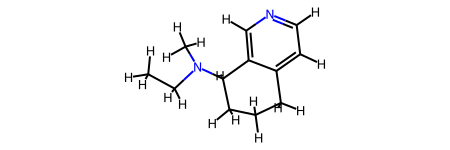

In [29]:
m3ds[0][1]

Run the eHT calculation each molecule, grab the computed properties from those results, and store everything in the database:

In [30]:
for mid,mh in m3ds:
    # run the calculation:
    ok,res = rdEHTTools.RunMol(mh)
    if not ok:
        continue
    # grab the atomic charges:
    d = {'atomic_charges':list(res.GetAtomicCharges())}
    
    # now find the reduced overlap populations for the bonds:
    opm = res.GetReducedOverlapPopulationMatrix()
    bnds = []
    nats = mh.GetNumAtoms()
    for bond in mh.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if a1<a2:
            a1,a2 = a2,a1
        # the matrix is symmetric and stored in a compressed form, here's how to 
        # get element opm[a1][a2] where a1>a2:
        o = opm[(a1*(a1+1))//2 + a2]
        bnds.append(o)
    d['mulliken_overlap_pops'] = bnds
    
    # store the results in the database
    curs.execute('insert into experiments_data (expt_uid, molregno, data) values (?, ?, ?)',(qm_expt_uid,mid,json.dumps(d)))
cn.commit()

!!! Warning !!! Distance between atoms 51 and 19 (0.987491 A) is suspicious.
!!! Warning !!! Distance between atoms 43 and 11 (0.986334 A) is suspicious.


Check how many results we have

In [31]:
%sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select count(*) from experiments_data where expt_uid=:qm_expt_uid

count(*)
10


retrieve the reduced overlap populations for each molecule's bonds as an array:

In [32]:
%sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select molregno,data->>'mulliken_overlap_pops' from experiments_data \
    where experiments_data.expt_uid=:qm_expt_uid limit 10;

molregno,data->>'mulliken_overlap_pops'
1,"[0.7532468211409893,0.6828602786586407,0.6617527295381088,0.686789647205431,0.8047796773162955,0.7674382521007178,0.7270912892798937,0.7907108555888139,1.0985357530889024,1.1160373477943286,0.9586451508417231,0.9246392621189311,1.120133281193136,0.8086650301709231,1.093755172650467,0.7937431041759968,0.7849122353066897,0.7725327495332708,0.799683658911537,0.8037466689131881,0.7879077698029229,0.8009934598831069,0.8051125926633401,0.7856679530405674,0.7973882060814462,0.7739388510344183,0.7938490825580038,0.7979650355109786,0.799295842873313,0.7945679092073765,0.7991485930946862,0.8019561567638424,0.815038371844909]"
2,"[0.7776074296047532,0.7981245155914027,0.7402918103744955,0.7394442582890376,0.7645540762243164,0.753257904124829,0.7330039079744686,0.7688444074729129,0.7612749173440101,0.7959239001225229,1.0943520925839778,0.6280289912613681,0.5949270281383111,1.1176317970562848,1.0854349052742203,1.0873146661943047,1.102042831330051,0.8047801108423144,0.7424616648874904,0.7855511052972423,1.130388401679868,0.7635682213545082,0.7894068199929912,0.774659993786233,0.7798604945905745,0.7657688928025637,0.7604598014610494,0.7842526084670424,0.7924836403145556,0.8109192077368879,0.8033484250953407,0.7824665344315456,0.7821602219724715,0.7807472548878164,0.7903689501000614,0.8076297103625848,0.7966266045393215,0.8035562511767542,0.7823310643214242,0.7856332138627591,0.7855108428248129,0.7801718856823868,0.7684330533956807,0.7972884802230149,0.8096237554674958,0.7914992445304453,0.800369875037509,0.7864442491317237,0.7972311109721082,0.7708578109754083]"
3,"[0.6998966051949411,0.7169850229756896,0.7733231772732382,0.7020740620290026,0.7228112674907962,0.7700735894660973,0.8752653889585522,0.9483198454343278,0.9347489614111906,1.0981447089715228,1.1040389517859552,0.934598345192769,0.8328870821646037,1.1840732899314035,0.8901536077289537,0.9721377269389172,0.9810154048003767,0.909878268086808,1.0801666205842568,1.0967868490231032,1.085899903020373,1.0951684252654614,1.09967565678217,0.70113552972067,0.9515145843256454,0.8689455967865616,1.0850628094936146,0.7738227007994108,0.7883234426128083,0.7881530654342113,0.7788786201321252,0.7806239726376262,0.7886981102890374,0.7780791215694088,0.7829284007677627,0.8036338473432548,0.778574749161318,0.7974654100097972,0.7999416122114418,0.8081561690086344,0.802047184181091,0.7075583866580832,0.8004013285790598,0.802657748346212,0.8034533703585053,0.7927973234821776,0.8068798844318671]"
4,"[0.7715466420829221,0.7535660877170369,0.7186719197003808,0.705629562518978,0.7786885677580951,0.7356634392651826,0.7865204610686656,0.7931171342665433,0.7493406458916346,0.7926561562933759,1.1009218958315479,1.1048110015283514,1.0713791618333741,0.97405157672337,1.2101217913324662,0.7262729211961716,0.7108198153093606,1.0922778250849796,0.7296146659267544,0.8263428699707818,1.1163635031089567,1.0822831788147256,0.7725929822921345,0.7779985446826585,0.7948908926411696,0.7812062599955247,0.7946119476218869,0.7851687123997784,0.79932467054453,0.7906992437961013,0.7933497383432228,0.7980913725104072,0.7987933666925339,0.7888573932753689,0.7958440815274428,0.7943604902641426,0.7863327464874585,0.7897296589863232,0.7825772994911939,0.7974838017303526,0.804866247027607,0.7862099061077475,0.7953130398858798]"
5,"[0.576442765270729,0.6243121725077688,1.1154287841624209,1.0788123143436879,1.0915665380520825,1.1124254823233173,0.6079063517483173,0.5666910572828466,0.8005964769024865,0.785724979598099,0.727156169904026,0.6746759826186417,0.8004245303856656,0.7486808237191919,0.7672190920601899,0.8021950899393675,0.8005443920129678,0.5653122233882449,0.8009493362192097,0.783603710242938,1.153281345715514,0.7696360932968856,0.7458398097016247,1.1036056183223306,1.1015580341214475,1.0752493905369416,1.1373220498638326,1.0026795012594065,0.5437347614606238,0.6069700661731475,1.1127588935982666,1.1107034741184116,0.6934400239895708,0.7737737739016102,1.0863047733606364,1.0545945339

Max reduced overlap population in each molecule

In [33]:
%sql sqlite:///lwreg_experiments_demo.sqlite3 \
  select molregno,max(mops.value) from \
    experiments_data ed,json_each(ed.data->'mulliken_overlap_pops') mops \
    where expt_uid=:qm_expt_uid  group by molregno;

molregno,max(mops.value)
1,1.120133281193136
2,1.130388401679868
3,1.1840732899314035
4,1.2101217913324662
5,1.153281345715514
6,1.1839563884440143
7,1.154788081239401
8,1.1162449714905849
9,1.2979538719868124
10,1.1477531159555596


Max and min charges in each molecule

In [34]:
%sql sqlite:///lwreg_experiments_demo.sqlite3 \
  select molregno,max(mops.value),min(mops.value) from \
    experiments_data ed,json_each(ed.data->'atomic_charges') mops \
    where expt_uid=:qm_expt_uid  group by molregno;

molregno,max(mops.value),min(mops.value)
1,0.32207929379970324,-0.8415317006684404
2,0.4464337591830656,-0.7275443528624947
3,0.9223286627423888,-0.9845470892724062
4,0.4094480942687895,-0.6308753886232896
5,0.504622497533133,-0.8412284460643846
6,0.43105816536369446,-0.6189208077307082
7,0.5656531859020788,-0.8853606953343736
8,0.44264233360152616,-0.7758854367973527
9,0.6302052232843918,-0.7655907009219209
10,0.5218461316287515,-0.8773649904919394


Extract the arrays directly

In [35]:
d = %sql sqlite:///lwreg_experiments_demo.sqlite3 \
  select molregno,data->'atomic_charges' \
    from experiments_data where expt_uid=:qm_expt_uid;
d[0][1]

'[-0.07284737178542855,0.24796048617872657,-0.6929872801972579,0.19616673124573936,0.29707145753664577,-0.014495393909541576,-0.004142665676567958,-0.04680858422796064,0.1793341410673861,-0.09795212113724006,0.32207929379970324,-0.8415317006684404,0.2883012413368533,0.0010110412434585214,0.024768164552369853,0.015618090578755073,0.007965459675233433,0.004645703826099634,0.00517717487673508,0.0011626988480202272,0.01792055617988808,0.01695297010610375,-0.007850034176954068,0.015216652565868571,-0.011135999138787156,0.0082506491598906,0.009519949333480326,0.014629170615918952,0.03220310606286603,0.027335976305039367,0.027839451192448905,0.028621000621569692]'

Note that the above is a string, *not* a list, but we can safely convert it to a list of numbers:

In [36]:
json.loads(d[0][1])

[-0.07284737178542855,
 0.24796048617872657,
 -0.6929872801972579,
 0.19616673124573936,
 0.29707145753664577,
 -0.014495393909541576,
 -0.004142665676567958,
 -0.04680858422796064,
 0.1793341410673861,
 -0.09795212113724006,
 0.32207929379970324,
 -0.8415317006684404,
 0.2883012413368533,
 0.0010110412434585214,
 0.024768164552369853,
 0.015618090578755073,
 0.007965459675233433,
 0.004645703826099634,
 0.00517717487673508,
 0.0011626988480202272,
 0.01792055617988808,
 0.01695297010610375,
 -0.007850034176954068,
 0.015216652565868571,
 -0.011135999138787156,
 0.0082506491598906,
 0.009519949333480326,
 0.014629170615918952,
 0.03220310606286603,
 0.027335976305039367,
 0.027839451192448905,
 0.028621000621569692]

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('tableau-colorblind10')

Plot C-C overlap population vs distance for these molecules

In [38]:
import ast

rows = %sql sqlite:///lwreg_experiments_demo.sqlite3 \
    select molregno,data->>'mulliken_overlap_pops' from experiments_data \
    where experiments_data.expt_uid=:qm_expt_uid limit 10;
cc_mops = []
cc_dists = []
cc_bos = []
for mrn,mops in rows:
    mops = ast.literal_eval(mops)
    mol = None
    for tpl in m3ds:
        if tpl[0]==mrn:
            mol = tpl[1]
            break
    assert mol is not None
    conf = mol.GetConformer()
    for idx,mop in enumerate(mops):
        bnd = mol.GetBondWithIdx(idx)
        if bnd.GetBeginAtom().GetAtomicNum()==6 and bnd.GetEndAtom().GetAtomicNum()==6:
            dist = (conf.GetAtomPosition(bnd.GetBeginAtomIdx())-conf.GetAtomPosition(bnd.GetEndAtomIdx())).Length()
            cc_mops.append(mop)
            cc_dists.append(dist)
            cc_bos.append(bnd.GetBondType())
    

In [39]:
from collections import defaultdict
cc_dists_1 = defaultdict(list)
cc_mops_1 = defaultdict(list)
for bo,d,mop in zip(cc_bos,cc_dists,cc_mops):
    cc_dists_1[bo].append(d)
    cc_mops_1[bo].append(mop)
        

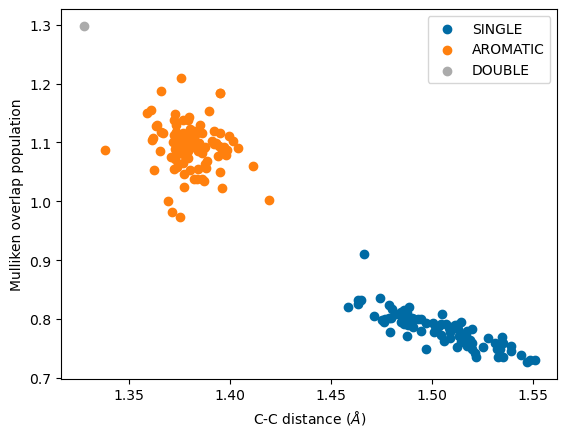

In [41]:
for k in cc_dists_1.keys():
    plt.scatter(cc_dists_1[k],cc_mops_1[k],label=str(k))
plt.legend()
plt.xlabel(r'C-C distance ($\AA$)')
plt.ylabel('Mulliken overlap population');